# Objective

Perform the exploratory data analysis (EDA) to find insights in the AWS pricing data

# Code

## Load libs

In [1]:
import sys
sys.path.append('..')

import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from src.data.helpers import load_aws_dataset

## Input params

In [2]:
interim_dir = '../data/interim'
in_fname = 'step_1_aws_filtered_sample.csv.zip'
compression = 'zip'

In [3]:
# Papermill parameters injection ... do not delete!

## Load data

In [4]:
file = f'{interim_dir}/{in_fname}'
data = load_aws_dataset(file)
print(data.shape)
data.head()

(1666418, 4)


/Users/walterwong/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Timestamp,AvailabilityZone,InstanceType,SpotPrice
0,2020-06-01 00:00:04,us-east-1f,r5d.large,0.0356
1,2020-06-01 00:00:04,us-east-1c,r5d.large,0.0356
2,2020-06-01 00:00:04,us-east-1d,r5d.large,0.0356
3,2020-06-01 00:00:04,us-east-1b,r5d.large,0.0356
4,2020-06-01 00:00:50,us-west-2c,r5.2xlarge,0.1560


## Data wrangling

Let's find something interesting in the data!
- Look for most volatile instances, i.e., with more price changes, thus to avoid them;
- Least volatile instances;
- Longer price update times;

### Data check-up for nulls and missing values

Assumptions:

- Considered region: us-east-1a (Virginia);
- Check presence of null columns (i.e., there is no price change on that);

In [5]:
%%time

df = data.query('AvailabilityZone == "us-east-1a"')\
         .drop('AvailabilityZone', axis=1)

print(df.shape)

# Pivot table to change a wide format for the data. Thus, we can remove
# instances that do not have any price update.
# Dropping MultiIndex column 'SpotPrice' as there is no use for it.
pvt = df.pivot_table(index=['Timestamp'], 
                     columns=['InstanceType'])\
        .droplevel(0, axis=1)

pvt.head()

(58756, 3)
CPU times: user 414 ms, sys: 193 ms, total: 608 ms
Wall time: 609 ms


InstanceType,a1.2xlarge,a1.4xlarge,a1.large,a1.medium,a1.metal,a1.xlarge,c1.medium,c1.xlarge,c3.2xlarge,c3.4xlarge,...,x1e.4xlarge,x1e.8xlarge,x1e.xlarge,z1d.12xlarge,z1d.2xlarge,z1d.3xlarge,z1d.6xlarge,z1d.large,z1d.metal,z1d.xlarge
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-01 00:05:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01 00:05:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01 00:06:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01 00:13:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01 00:14:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Checking if there is any column with only 'NaN'
# Returns None, meaning that all 
pvt.isna().all(axis=0).loc[lambda x: x.isna()]

Series([], dtype: bool)

In [7]:
# Cross-check to see if this is correct. Getting a sample of confirm this
# using instance 'a1.2xlarge'
pvt['a1.2xlarge'].dropna().head()

Timestamp
2020-06-01 05:22:38    0.0671
2020-06-02 05:23:04    0.0671
2020-06-03 05:23:48    0.0671
2020-06-04 05:24:13    0.0671
2020-06-05 05:24:36    0.0671
Name: a1.2xlarge, dtype: float64

In [8]:
# Picking random instance and checking if the values are not null
# just for sanity check.
for i in range(5):
    rand_instance = random.randint(0, len(pvt.columns))
    tmp = pvt.iloc[rand_instance].dropna().head()
    print(tmp)

InstanceType
i3.16xlarge    1.4976
Name: 2020-06-01 10:00:03, dtype: float64
InstanceType
m4.2xlarge    0.1587
Name: 2020-06-01 11:07:56, dtype: float64
InstanceType
r5.2xlarge    0.1796
Name: 2020-06-01 14:04:08, dtype: float64
InstanceType
m3.large    0.0308
Name: 2020-06-01 13:56:20, dtype: float64
InstanceType
r5dn.24xlarge    2.5579
r5dn.xlarge      0.0745
Name: 2020-06-01 06:47:45, dtype: float64


### Most volatile instances

In [9]:
# Now getting the most volatile instances
most_volatiles = pvt.count().sort_values(ascending=False).nlargest(10)
most_volatiles

InstanceType
r5n.16xlarge     377
r5.16xlarge      377
m5.16xlarge      377
r5.12xlarge      376
g4dn.12xlarge    374
m5a.4xlarge      374
m5a.8xlarge      373
m4.16xlarge      373
r5a.8xlarge      372
r5a.16xlarge     372
dtype: int64

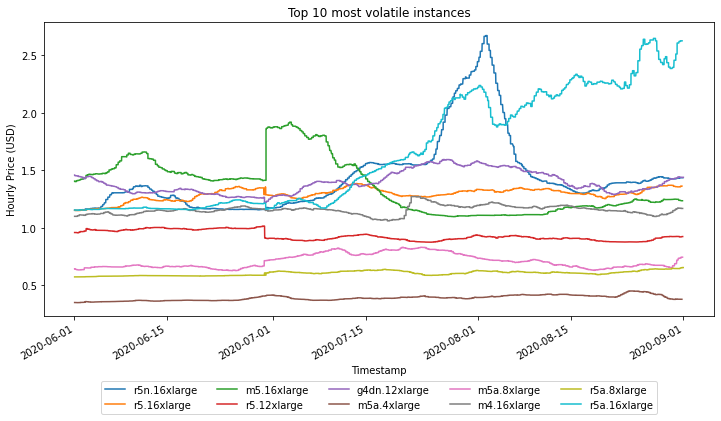

In [10]:
# Let's quickly plot to see the pricing trends
# Some normalization is required:
# 1. Remove rows with only NaN (not columns, otherwise it will remove all pricing!);
# 2. There are gaps in the pricing. This happens because if there is no pricing
# update, then there is not price capture. Thus, we can safely use backwards fill
# to fill the missing values

fig, ax = plt.subplots(figsize=(12, 6))

pvt.loc[:, most_volatiles.index.to_list()]\
    .dropna(how='all', axis=0)\
    .fillna(method='bfill').plot(ax=ax)

ax.set_title('Top 10 most volatile instances')
ax.set_ylabel('Hourly Price (USD)')
ax.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.35))

### Least volatile instances

In [11]:
# Now getting the least volatile instances
least_volatiles = pvt.count().sort_values(ascending=False).nsmallest(10)
least_volatiles

InstanceType
c5ad.large       19
c5ad.4xlarge     19
c5ad.16xlarge    19
c5ad.8xlarge     19
c5ad.xlarge      20
c5ad.12xlarge    20
c5ad.24xlarge    20
c5ad.2xlarge     22
r5ad.8xlarge     23
m5ad.16xlarge    23
dtype: int64

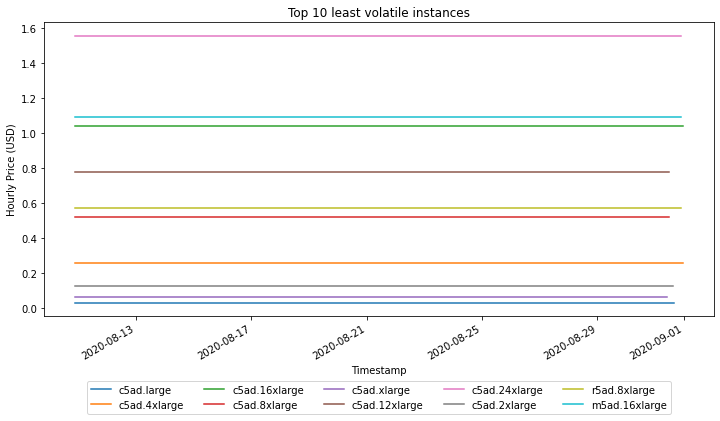

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

pvt.loc[:, least_volatiles.index.to_list()]\
    .dropna(how='all', axis=0)\
    .fillna(method='bfill').plot(ax=ax)

ax.set_title('Top 10 least volatile instances')
ax.set_ylabel('Hourly Price (USD)')
ax.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.35))